In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


In [46]:
# Load data
df = pd.read_csv('./Datasets/master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x', 'accel_y', 'accel_z',
    'gyro_x', 'gyro_y', 'gyro_z',
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['File ID'].unique():
    segment_df = df[df['File ID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [47]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [48]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask



In [49]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [50]:
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.causal_conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.activation = nn.ReLU()
        self.residual_conv = nn.Conv1d(out_channels, in_channels, kernel_size=1)

    def forward(self, x):
        out = self.causal_conv(x)
        out = out[:, :, :-self.causal_conv.padding[0]]  # remove padding for causality
        out = self.activation(out)
        res = self.residual_conv(out)
        return res + x  # residual connection

class IMU2EMG_WaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2):
        super(IMU2EMG_WaveNet, self).__init__()
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        return x


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pywt
from scipy import signal
from scipy.stats import pearsonr

class BasicLosses:
    """Basic loss functions for wave generation"""
    
    @staticmethod
    def mse_loss(pred, target):
        """Mean Squared Error"""
        return F.mse_loss(pred, target)
    
    @staticmethod
    def mae_loss(pred, target):
        """Mean Absolute Error"""
        return F.l1_loss(pred, target)
    
    @staticmethod
    def rmse_loss(pred, target):
        """Root Mean Squared Error"""
        return torch.sqrt(F.mse_loss(pred, target))
    
    @staticmethod
    def huber_loss(pred, target, delta=1.0):
        """Huber Loss - robust to outliers"""
        return F.huber_loss(pred, target, delta=delta)

class SignalQualityLosses:
    """Signal quality based loss functions"""
    
    @staticmethod
    def snr_loss(pred, target, eps=1e-8):
        """Signal-to-Noise Ratio based loss (higher SNR = lower loss)"""
        signal_power = torch.mean(target ** 2, dim=-1, keepdim=True)
        noise_power = torch.mean((pred - target) ** 2, dim=-1, keepdim=True)
        snr = 10 * torch.log10(signal_power / (noise_power + eps))
        return -torch.mean(snr)  # Negative because we want to maximize SNR
    
    @staticmethod
    def psnr_loss(pred, target, max_val=1.0, eps=1e-8):
        """Peak Signal-to-Noise Ratio based loss"""
        mse = torch.mean((pred - target) ** 2)
        psnr = 20 * torch.log10(max_val / (torch.sqrt(mse) + eps))
        return -psnr  # Negative because we want to maximize PSNR

class CorrelationLosses:
    """Correlation-based loss functions"""
    
    @staticmethod
    def cosine_similarity_loss(pred, target, dim=-1, eps=1e-8):
        """Cosine similarity loss (1 - cosine_similarity)"""
        cos_sim = F.cosine_similarity(pred, target, dim=dim, eps=eps)
        return 1 - torch.mean(cos_sim)
    
    @staticmethod
    def pearson_correlation_loss(pred, target, eps=1e-8):
        """Pearson correlation coefficient loss"""
        # Compute means
        pred_mean = torch.mean(pred, dim=-1, keepdim=True)
        target_mean = torch.mean(target, dim=-1, keepdim=True)
        
        # Center the data
        pred_centered = pred - pred_mean
        target_centered = target - target_mean
        
        # Compute correlation
        numerator = torch.sum(pred_centered * target_centered, dim=-1)
        pred_std = torch.sqrt(torch.sum(pred_centered ** 2, dim=-1) + eps)
        target_std = torch.sqrt(torch.sum(target_centered ** 2, dim=-1) + eps)
        
        correlation = numerator / (pred_std * target_std + eps)
        return 1 - torch.mean(correlation)

class FrequencyDomainLosses:
    """Frequency domain loss functions"""
    
    @staticmethod
    def spectral_convergence_loss(pred, target, eps=1e-7):
        """Spectral convergence loss using FFT"""
        pred_fft = torch.fft.fft(pred, dim=-1)
        target_fft = torch.fft.fft(target, dim=-1)
        
        pred_mag = torch.abs(pred_fft)
        target_mag = torch.abs(target_fft)
        
        numerator = torch.norm(pred_mag - target_mag, p='fro')
        denominator = torch.norm(target_mag, p='fro')
        
        return numerator / (denominator + eps)
    
    @staticmethod
    def stft_distance_loss(pred, target, n_fft=1024, hop_length=256, win_length=1024):
        """Short-Time Fourier Transform distance loss"""
        # Create window
        window = torch.hann_window(win_length, device=pred.device)
        
        # Compute STFT
        pred_stft = torch.stft(pred.view(-1), n_fft=n_fft, hop_length=hop_length, 
                              win_length=win_length, window=window, return_complex=True)
        target_stft = torch.stft(target.view(-1), n_fft=n_fft, hop_length=hop_length,
                                win_length=win_length, window=window, return_complex=True)
        
        # Magnitude loss
        pred_mag = torch.abs(pred_stft)
        target_mag = torch.abs(target_stft)
        
        mag_loss = F.l1_loss(pred_mag, target_mag)
        
        # Phase loss (using cosine distance)
        pred_phase = torch.angle(pred_stft)
        target_phase = torch.angle(target_stft)
        phase_loss = 1 - F.cosine_similarity(pred_phase.flatten(), target_phase.flatten(), dim=0)
        
        return mag_loss + 0.1 * phase_loss

class WaveletLosses:
    """Wavelet-based loss functions"""
    
    @staticmethod
    def dwt_loss(pred, target, wavelet='db2', levels=4):
        """Discrete Wavelet Transform loss"""
        device = pred.device
        total_loss = 0
        
        # Convert to numpy for pywt
        pred_np = pred.detach().cpu().numpy()
        target_np = target.detach().cpu().numpy()
        
        batch_size = pred_np.shape[0]
        
        for i in range(batch_size):
            # Perform DWT
            pred_coeffs = pywt.wavedec(pred_np[i].flatten(), wavelet, level=levels)
            target_coeffs = pywt.wavedec(target_np[i].flatten(), wavelet, level=levels)
            
            # Compute loss for each level
            for p_coeff, t_coeff in zip(pred_coeffs, target_coeffs):
                p_tensor = torch.tensor(p_coeff, device=device, dtype=torch.float32)
                t_tensor = torch.tensor(t_coeff, device=device, dtype=torch.float32)
                total_loss += F.mse_loss(p_tensor, t_tensor)
        
        return total_loss / batch_size

class EnvelopeLosses:
    """Envelope-based loss functions"""
    
    @staticmethod
    def envelope_similarity_loss(pred, target):
        """Envelope similarity using moving average of absolute values"""
        # Ensure pred and target are 2D: (batch_size, seq_len)
        if len(pred.shape) == 1:
            pred = pred.unsqueeze(0)
        if len(target.shape) == 1:
            target = target.unsqueeze(0)
            
        batch_size, seq_len = pred.shape
        
        # Adaptive kernel size
        kernel_size = min(50, seq_len // 10)
        if kernel_size < 3:
            kernel_size = 3
        
        # Make kernel size odd for symmetric padding
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = torch.ones(1, 1, kernel_size, device=pred.device) / kernel_size
        
        # Reshape for conv1d: (batch_size, 1, seq_len)
        pred_reshaped = torch.abs(pred).unsqueeze(1)
        target_reshaped = torch.abs(target).unsqueeze(1)
        
        # Apply convolution with proper padding
        padding = kernel_size // 2
        pred_env = F.conv1d(pred_reshaped, kernel, padding=padding)
        target_env = F.conv1d(target_reshaped, kernel, padding=padding)
        
        # Remove the channel dimension: (batch_size, seq_len)
        pred_env = pred_env.squeeze(1)
        target_env = target_env.squeeze(1)
        
        return F.mse_loss(pred_env, target_env)
    
    @staticmethod
    def rms_envelope_loss(pred, target, window_size=50):
        """RMS envelope loss"""
        # Ensure proper shape
        if len(pred.shape) == 1:
            pred = pred.unsqueeze(0)
        if len(target.shape) == 1:
            target = target.unsqueeze(0)
            
        batch_size, seq_len = pred.shape
        
        # Adaptive window size
        window_size = min(window_size, seq_len // 5)
        if window_size < 3:
            window_size = 3
        if window_size % 2 == 0:
            window_size += 1
        
        # Pad sequences
        pad_size = window_size // 2
        pred_padded = F.pad(pred, (pad_size, pad_size), mode='reflect')
        target_padded = F.pad(target, (pad_size, pad_size), mode='reflect')
        
        # Reshape for pooling: (batch_size, 1, seq_len)
        pred_padded = pred_padded.unsqueeze(1)
        target_padded = target_padded.unsqueeze(1)
        
        # Compute RMS envelope
        pred_rms = torch.sqrt(F.avg_pool1d(pred_padded ** 2, 
                                          kernel_size=window_size, stride=1))
        target_rms = torch.sqrt(F.avg_pool1d(target_padded ** 2,
                                            kernel_size=window_size, stride=1))
        
        # Remove channel dimension
        pred_rms = pred_rms.squeeze(1)
        target_rms = target_rms.squeeze(1)
        
        return F.mse_loss(pred_rms, target_rms)

class CombinedLosses:
    """Combined loss functions for better training"""
    
    @staticmethod
    def multi_scale_loss(pred, target, scales=[1, 2, 4, 8]):
        """Multi-scale loss using different pooling scales"""
        total_loss = 0
        
        # Ensure proper shape for pooling
        if len(pred.shape) == 1:
            pred = pred.unsqueeze(0)
        if len(target.shape) == 1:
            target = target.unsqueeze(0)
        
        for scale in scales:
            if scale == 1:
                scaled_pred = pred
                scaled_target = target
            else:
                # Check if we have enough samples for this scale
                if pred.shape[-1] < scale:
                    continue
                    
                # Reshape for pooling: (batch_size, 1, seq_len)
                pred_pooling = pred.unsqueeze(1) if len(pred.shape) == 2 else pred
                target_pooling = target.unsqueeze(1) if len(target.shape) == 2 else target
                
                scaled_pred = F.avg_pool1d(pred_pooling, kernel_size=scale, stride=scale)
                scaled_target = F.avg_pool1d(target_pooling, kernel_size=scale, stride=scale)
                
                # Remove channel dimension if added
                if scaled_pred.shape[1] == 1:
                    scaled_pred = scaled_pred.squeeze(1)
                    scaled_target = scaled_target.squeeze(1)
            
            total_loss += F.mse_loss(scaled_pred, scaled_target)
        
        return total_loss / len(scales)
    
    @staticmethod
    def hybrid_loss(pred, target, weights={'mse': 1.0, 'cosine': 0.5, 'envelope': 0.3}):
        """Hybrid loss combining multiple objectives"""
        total_loss = 0
        
        if 'mse' in weights:
            total_loss += weights['mse'] * F.mse_loss(pred, target)
        
        if 'cosine' in weights:
            # Ensure we have at least 2D tensors for cosine similarity
            if len(pred.shape) == 1:
                pred_cos = pred.unsqueeze(0)
                target_cos = target.unsqueeze(0)
            else:
                pred_cos = pred
                target_cos = target
                
            cos_sim = F.cosine_similarity(pred_cos, target_cos, dim=-1)
            total_loss += weights['cosine'] * (1 - torch.mean(cos_sim))
        
        if 'envelope' in weights:
            env_loss = EnvelopeLosses.envelope_similarity_loss(pred, target)
            total_loss += weights['envelope'] * env_loss
        
        return total_loss

# Usage example with your training loop
def get_loss_function(loss_type='mse', **kwargs):
    """Factory function to get different loss functions"""
    
    loss_functions = {
        # Basic losses
        'mse': BasicLosses.mse_loss,
        'mae': BasicLosses.mae_loss,
        'rmse': BasicLosses.rmse_loss,
        'huber': lambda p, t: BasicLosses.huber_loss(p, t, **kwargs),
        
        # Signal quality
        'snr': SignalQualityLosses.snr_loss,
        'psnr': SignalQualityLosses.psnr_loss,
        
        # Correlation
        'cosine': CorrelationLosses.cosine_similarity_loss,
        'pearson': CorrelationLosses.pearson_correlation_loss,
        
        # Frequency domain
        'spectral': FrequencyDomainLosses.spectral_convergence_loss,
        'stft': FrequencyDomainLosses.stft_distance_loss,
        
        # Wavelet
        # 'dwt': WaveletLosses.dwt_loss, # This is un-usable because it requires numpy arrays and tensor to numpy conversion breaks the autograd
        
        # Envelope
        'envelope': EnvelopeLosses.envelope_similarity_loss,
        'rms_envelope': EnvelopeLosses.rms_envelope_loss,
        
        # Combined
        'multi_scale': CombinedLosses.multi_scale_loss,
        'hybrid': lambda p, t: CombinedLosses.hybrid_loss(p, t, **kwargs)
    }
    
    return loss_functions.get(loss_type, BasicLosses.mse_loss)

In [52]:
# Modified training loop example
def train_with_custom_loss(model, dataloader, loss_type='hybrid', num_epochs=500):
    """Training loop with custom loss function"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Get custom loss function
    if loss_type == 'hybrid':
        criterion = get_loss_function('hybrid', weights={'mse': 1.0, 'cosine': 0.3, 'envelope': 0.2})
    else:
        criterion = get_loss_function(loss_type)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    loss_history = []
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for imu_batch, emg_batch, pad_mask in dataloader:
            imu_batch = imu_batch.to(device)
            emg_batch = emg_batch.to(device)
            pad_mask = pad_mask.to(device)
            
            optimizer.zero_grad()
            outputs = model(imu_batch)
            
            # Apply mask
            outputs_masked = outputs[~pad_mask]
            emg_masked = emg_batch[~pad_mask]
            
            # Reshape for loss calculation
            if len(outputs_masked.shape) > 1:
                outputs_masked = outputs_masked.view(-1)
                emg_masked = emg_masked.view(-1)
            
            # Calculate loss
            loss = criterion(outputs_masked, emg_masked)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)
        scheduler.step(avg_epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model.state_dict(), f'./model_checkpoint/shubhranil/model_best_all_raw_{loss_type}.pth')
            print(f"Best model saved with {loss_type} loss: {best_loss:.4f}")
    
    return loss_history

In [53]:
# Initialize model
num_imu_features = len(imu_features)
model = IMU2EMG_WaveNet(imu_features=num_imu_features, hidden_channels=64, num_blocks=5, kernel_size=8)

In [54]:
# Start training
print("Starting training...")
loss_type = 'snr'
loss_history = train_with_custom_loss(
    model=model,
    dataloader=dataloader,
    loss_type=loss_type,
    num_epochs=500
)

Starting training...
Epoch [1/500], Loss: 3.0302, LR: 0.000500
Best model saved with snr loss: 3.0302
Epoch [2/500], Loss: 1.8004, LR: 0.000500
Best model saved with snr loss: 1.8004
Epoch [3/500], Loss: 0.4452, LR: 0.000500
Best model saved with snr loss: 0.4452
Epoch [4/500], Loss: 0.3162, LR: 0.000500
Best model saved with snr loss: 0.3162
Epoch [5/500], Loss: 0.1864, LR: 0.000500
Best model saved with snr loss: 0.1864
Epoch [6/500], Loss: 0.1265, LR: 0.000500
Best model saved with snr loss: 0.1265
Epoch [7/500], Loss: 0.0674, LR: 0.000500
Best model saved with snr loss: 0.0674
Epoch [8/500], Loss: 0.0556, LR: 0.000500
Best model saved with snr loss: 0.0556
Epoch [9/500], Loss: 0.0841, LR: 0.000500
Epoch [10/500], Loss: 0.0705, LR: 0.000500
Epoch [11/500], Loss: 0.0624, LR: 0.000500
Epoch [12/500], Loss: 0.0222, LR: 0.000500
Best model saved with snr loss: 0.0222
Epoch [13/500], Loss: 0.0477, LR: 0.000500
Epoch [14/500], Loss: 0.0263, LR: 0.000500
Epoch [15/500], Loss: 0.0043, LR: 0

KeyboardInterrupt: 

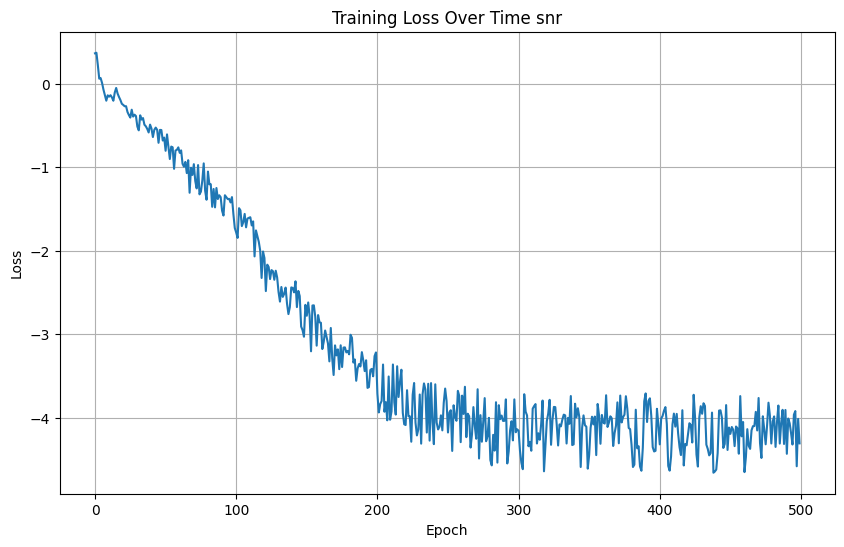

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title(f'Training Loss Over Time {loss_type}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.show()
plt.savefig(f'./assets/loss_plot_all_raw_{loss_type}.png')

In [ ]:
# Recreate the model architecture
model = IMU2EMG_WaveNet(imu_features=num_imu_features, hidden_channels=64, num_blocks=5, kernel_size=8)
model.load_state_dict(torch.load(f'./model_checkpoint/shubhranil/model_best_all_raw_{loss_type}.pth'))

<All keys matched successfully>

In [ ]:
def predict_emg(model, imu_data, device):
    """
    Predict EMG from IMU data
    
    Args:
        model: Trained WaveNet model
        imu_data: numpy array of shape (seq_len, features) or (batch_size, seq_len, features)
        device: torch device
    
    Returns:
        numpy array of predicted EMG values
    """
    model.eval()
    
    # Convert to tensor
    if isinstance(imu_data, np.ndarray):
        imu_tensor = torch.tensor(imu_data, dtype=torch.float32)
    else:
        imu_tensor = imu_data
    
    # Add batch dimension if needed
    if len(imu_tensor.shape) == 2:
        imu_tensor = imu_tensor.unsqueeze(0)
    
    imu_tensor = imu_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(imu_tensor)
    
    # Convert to numpy and remove extra dimensions
    prediction_np = prediction.cpu().numpy().squeeze()
    
    return prediction_np  # Normalize to start from zero

# Usage:
predicted_emg = predict_emg(model, imu_segments[1], 'cpu')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
true_emg = np.array(emg_segments[1]).reshape(-1, 1)
pred_emg = predicted_emg.reshape(-1, 1)

# Fit scaler on both arrays concatenated to ensure same scale
scaler.fit(np.concatenate([true_emg, pred_emg], axis=0))
true_emg_norm = scaler.transform(true_emg).flatten()
pred_emg_norm = scaler.transform(pred_emg).flatten()

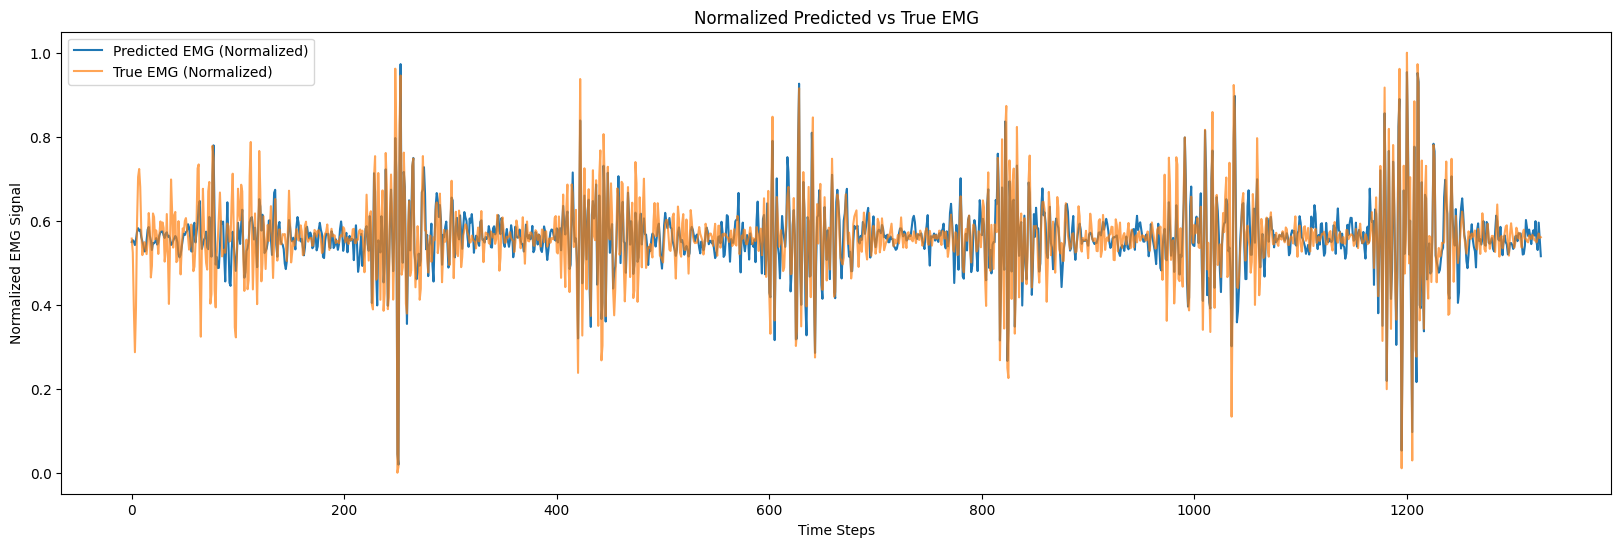

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(pred_emg_norm, label='Predicted EMG (Normalized)')
plt.plot(true_emg_norm, label='True EMG (Normalized)', alpha=0.7)
plt.title('Normalized Predicted vs True EMG')
plt.xlabel('Time Steps')
plt.ylabel('Normalized EMG Signal')
plt.legend()